# UNet-Resnet on Rescunet
## Baseline Model: UNet- Resnet34 
* Encoder: Resnet34 with weights pretrained on Imagenet
* Decoder: UNet

# Constants

In [1]:
import torch
TRAIN_IMG_SIZE = (480, 640, 3)
VAL_IMG_SIZE = TRAIN_IMG_SIZE
TEST_IMG_SIZE = TRAIN_IMG_SIZE
N_CLASSES = 12
TRAIN_BATCH_SIZE = 8
VAL_BATCH_SIZE = 8
TEST_BATCH_SIZE = 8
NUM_EPOCHS = 40
TRAIN_NUM_WORKERS = 4
VAL_NUM_WORKERS = 4
TEST_NUM_WORKERS = 4
PIN_MEMORY = True
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

LOAD_MODEL = False
START_EPOCH = 0
DATA_DIR ='../input/rescuenet/RescueNet'
print(DEVICE)

cuda


# Install Libraries

In [3]:
!pip install segmentation-models-pytorch
!pip install torchsummary
import segmentation_models_pytorch.utils


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 957.9 kB/s eta 0:00:00 0:00:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.3 MB/s eta 0:00:0000:0100:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=9aea2097f8680b3745436cb017e120ba0c033006ba98ccd6669e5c5a2da4221a
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=4f7bd664b28917322ec55d09a424afbbcde9b27dcc6b22f8327dbe46e6795fb1
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built e

# Import libraries

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import albumentations as albu
import cv2
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm


from torch.utils.data import Dataset, DataLoader

import segmentation_models_pytorch as smp
import torch
from torchsummary import summary

torch.set_default_dtype(torch.float32)

torch.backends.cudnn.benchmark = True


# Load Data


## Directories in the dataset

In [7]:
def get_dir(subPath):  
    image_dir = os.path.join(DATA_DIR, subPath, subPath+"-org-img/" )
    label_dir = os.path.join(DATA_DIR, subPath, subPath+"-label-img/" )
    return [image_dir, label_dir]

In [9]:
x_train_dir, y_train_dir = get_dir('train')
x_val_dir, y_val_dir = get_dir('val')
x_test_dir, y_test_dir = get_dir('test')

##  Form Filepath for original images and annotations

In [10]:
def listFiles(subPath):
    org_dir, label_dir = get_dir(subPath)
    df = pd.DataFrame(columns=['folder_path','image_name', 'extension'])

    for img in os.listdir(org_dir):
        info = {
            'folder_path': [org_dir], 
            'image_name': [img[0:5]], 
            'extension': ['jpg']}
        info_ = pd.DataFrame(data=info)
        df = pd.concat((df, info_))

    df = df.drop_duplicates(subset=['image_name'])

    imgs = df.iloc[:,0] + df.iloc[:,1] + '.jpg'
    imgs = imgs.reset_index(drop=True)
    labels = label_dir + df.iloc[:,1] + '_lab.png'
    labels = labels.reset_index(drop=True)

    df = pd.concat((imgs,labels),axis=1)
    return df

In [11]:
train_df = listFiles('train')
val_df = listFiles('val')
test_df = listFiles('test')
train_df.iloc[:, 1].values

array(['../input/rescuenet/RescueNet/train/train-label-img/13288_lab.png',
       '../input/rescuenet/RescueNet/train/train-label-img/11925_lab.png',
       '../input/rescuenet/RescueNet/train/train-label-img/11378_lab.png',
       ...,
       '../input/rescuenet/RescueNet/train/train-label-img/13877_lab.png',
       '../input/rescuenet/RescueNet/train/train-label-img/11205_lab.png',
       '../input/rescuenet/RescueNet/train/train-label-img/11590_lab.png'],
      dtype=object)

## Size of 3 subsets:
* train  3595   80%
* val    449    10%
* test   450    10%

In [88]:
print('train set size:',len(train_df))
print('val set size:',len(val_df))
print('test set size:',len(test_df))

train set size: 3595
val set size: 449
test set size: 450


In [89]:
#image, annotation
len(train_df.iloc[:, 1]) == len(train_df.iloc[:,0])

True

##  Load dataset into batches 
* preprocessing and augmentation(resizing,scaling, fliping, rotation)

In [12]:
class RescueNetDataset(Dataset):
    def __init__(self, df, transforms):
        super(RescueNetDataset, self).__init__()
        self.df = df
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_path, mask_path = self.df.loc[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
        
        transformed = self.transforms(image=img, mask=mask)
        img = transformed['image']
        mask = transformed['mask']
        
        
        img = img/255
        img = img.astype('float32')

        img = np.transpose(img, (2,0,1))
        
        mask_stacked = np.array([mask==0])
        for i in range(1, 12):
            mask_stacked = np.concatenate([mask_stacked, np.array([mask==i])])
        mask = mask_stacked.astype(int)
        mask = mask.astype('int64')
        
        img = torch.from_numpy(img)
        mask = torch.from_numpy(mask)
        
        return img, mask


train_transforms = albu.Compose([
    albu.RandomScale(scale_limit=0.1),
    albu.Flip(),
    albu.Rotate(limit=30),
    albu.Resize(TRAIN_IMG_SIZE[0], TRAIN_IMG_SIZE[1]),
])

val_transforms = albu.Compose([
    albu.Resize(VAL_IMG_SIZE[0], VAL_IMG_SIZE[1]),
])

test_transforms = albu.Compose([
    albu.Resize(TEST_IMG_SIZE[0], TEST_IMG_SIZE[1]),
])

train_dataset = RescueNetDataset(df=train_df, transforms=train_transforms)
val_dataset = RescueNetDataset(df=val_df, transforms=val_transforms)
test_dataset = RescueNetDataset(df=test_df, transforms=test_transforms)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=TRAIN_NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    drop_last=True
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=VAL_BATCH_SIZE,
    shuffle=False,
    num_workers=VAL_NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    drop_last=True,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=TEST_NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    drop_last=True,
)

## Show one batch of data as an example
* original image
* annotation image

torch.Size([8, 3, 480, 640]) torch.Size([8, 12, 480, 640])
torch.float32


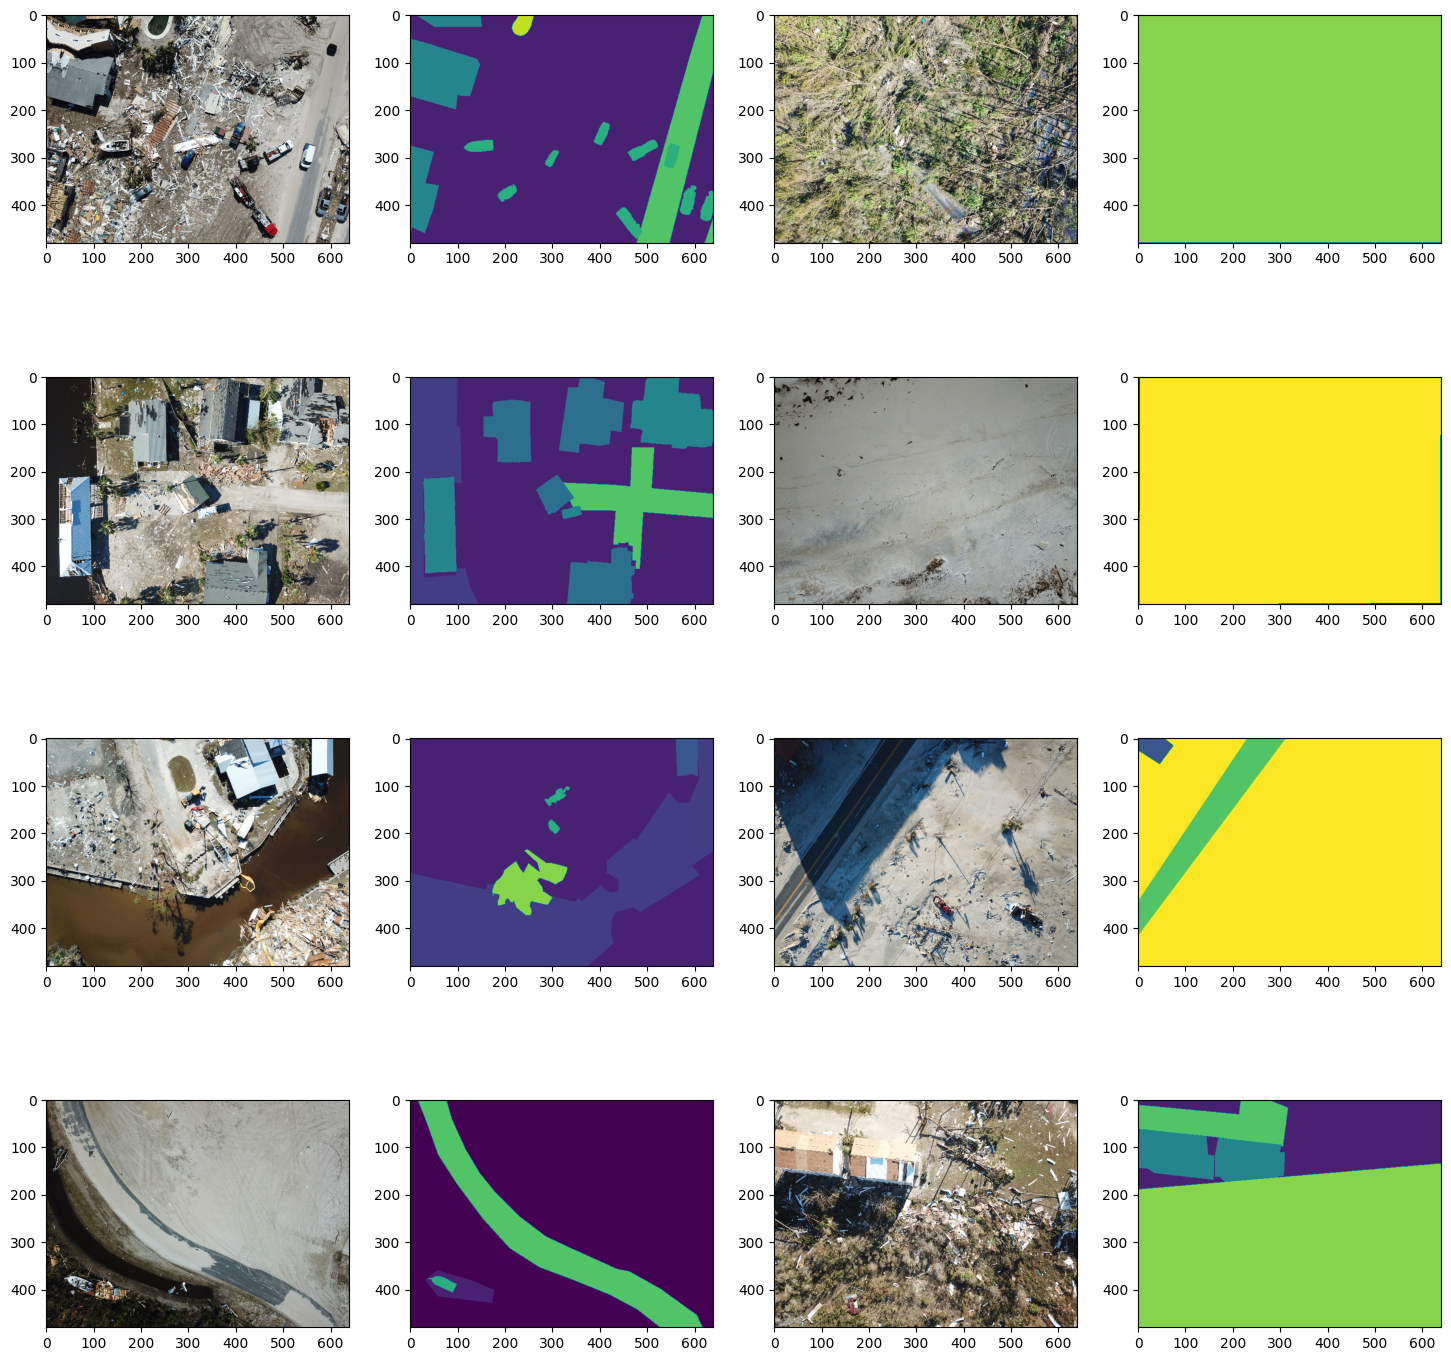

In [13]:
iterator = iter(train_loader)
imgs, masks = next(iterator)
print(imgs.shape, masks.shape)
print(imgs.dtype)

fig, axs = plt.subplots(nrows=4, ncols=4,figsize=(18,18))

count = 0
for r in range(4):
    #original image
    axs[r,0].imshow(imgs[count].permute(1,2,0))
    axs[r,1].imshow(np.argmax(masks[count], axis=0), vmin=0, vmax=11)
    count += 1
    #annotation
    axs[r,2].imshow(imgs[count].permute(1,2,0))
    axs[r,3].imshow(np.argmax(masks[count], axis=0), vmin=0, vmax=11)
    count += 1

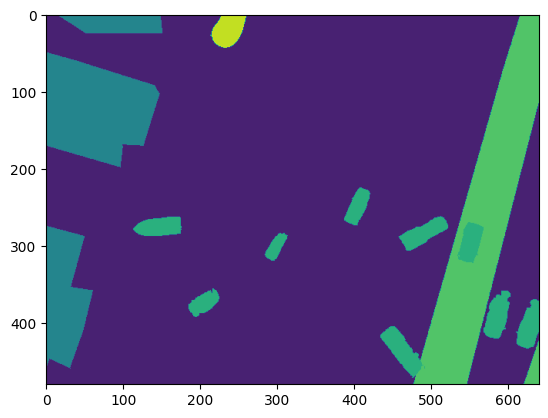

In [14]:
plt.imshow(np.argmax(masks[0], axis=0), vmin=0, vmax=11)


# Define the Model

In [15]:

model = smp.Unet('resnet34', encoder_weights='imagenet',  in_channels=3, classes=12).to(DEVICE)
summary(model, (3, 480, 640))

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 222MB/s] 


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 240, 320]           9,408
       BatchNorm2d-2         [-1, 64, 240, 320]             128
              ReLU-3         [-1, 64, 240, 320]               0
         MaxPool2d-4         [-1, 64, 120, 160]               0
            Conv2d-5         [-1, 64, 120, 160]          36,864
       BatchNorm2d-6         [-1, 64, 120, 160]             128
              ReLU-7         [-1, 64, 120, 160]               0
            Conv2d-8         [-1, 64, 120, 160]          36,864
       BatchNorm2d-9         [-1, 64, 120, 160]             128
             ReLU-10         [-1, 64, 120, 160]               0
       BasicBlock-11         [-1, 64, 120, 160]               0
           Conv2d-12         [-1, 64, 120, 160]          36,864
      BatchNorm2d-13         [-1, 64, 120, 160]             128
             ReLU-14         [-1, 64, 1

In [16]:
loss_fn = smp.losses.dice.DiceLoss(mode='multilabel')

loss_fn.__name__ = 'Dice_loss'

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

metric = [smp.utils.metrics.IoU()]

train_one_epoch = smp.utils.train.TrainEpoch(
    model=model,
    loss=loss_fn,
    metrics=metric,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True
)

val_one_epoch = smp.utils.train.ValidEpoch(
    model=model,
    loss=loss_fn,
    metrics=metric,
    device=DEVICE,
    verbose=True
)




## Load pretrained pytorch model

In [19]:
def load_checkpoint(path, model):
    print("=> Loading checkpoint")
    model.load_state_dict(torch.load(path))

In [74]:
!ls /kaggle/working/


checkpoint-16-0.30681613885930614.pth  state.db
checkpoint-18-0.29719530897481095.pth


# Train without early stop

In [ ]:
best_val_loss = float('inf')
for epoch in range(START_EPOCH, START_EPOCH + NUM_EPOCHS):

    print("EPOCH ", epoch)
    train_logs = train_one_epoch.run(dataloader=train_loader)
    print(train_logs)
    val_logs = val_one_epoch.run(dataloader=val_loader)
    print(val_logs)
    #compare the loss and save the best weights
    if val_logs['Dice_loss'] < best_val_loss:
        best_val_loss = val_logs['Dice_loss']
        torch.save(model.state_dict(), f'/kaggle/working/checkpoint-{epoch}-{best_val_loss}.pth')
    

# Train with best model and early stop

In [79]:
best_val_loss = float('inf')
epochs_no_improve = 0
n_epochs_stop = 5

for epoch in range(START_EPOCH, START_EPOCH + NUM_EPOCHS):
    print("EPOCH ", epoch)
    train_logs = train_one_epoch.run(dataloader=train_loader)
    print(train_logs)
    val_logs = val_one_epoch.run(dataloader=val_loader)
    print(val_logs)
    torch.save(model.state_dict(), f'/kaggle/working/checkpoint-{epoch}.pth')

    # If the validation loss is at a minimum
    if val_logs['Dice_loss'] < best_val_loss:
        epochs_no_improve = 0
        best_val_loss = val_logs['Dice_loss']
        # Save the model
        torch.save(model.state_dict(), f'/kaggle/working/checkpoint-{epoch}-{best_val_loss}.pth')
    else:
        epochs_no_improve += 1
        # Check early stopping condition
        if epochs_no_improve == n_epochs_stop:
            print('Early stopping!')
            break


EPOCH  19
train: 100%|██████████| 449/449 [12:01<00:00,  1.61s/it, Dice_loss - 0.31, iou_score - 0.6032]  
{'Dice_loss': 0.31002072302960587, 'iou_score': 0.6032351122003364}
valid: 100%|██████████| 56/56 [01:02<00:00,  1.12s/it, Dice_loss - 0.3208, iou_score - 0.631] 
{'Dice_loss': 0.3207661299301046, 'iou_score': 0.6309848411806993}
EPOCH  20
train: 100%|██████████| 449/449 [12:01<00:00,  1.61s/it, Dice_loss - 0.303, iou_score - 0.6147] 
{'Dice_loss': 0.3029654224824267, 'iou_score': 0.6146567816989201}
valid: 100%|██████████| 56/56 [01:04<00:00,  1.16s/it, Dice_loss - 0.3259, iou_score - 0.6108]
{'Dice_loss': 0.32594837407980654, 'iou_score': 0.6107681585209709}
EPOCH  21
train: 100%|██████████| 449/449 [12:09<00:00,  1.62s/it, Dice_loss - 0.301, iou_score - 0.6123] 
{'Dice_loss': 0.3009789558189747, 'iou_score': 0.612324957459966}
valid: 100%|██████████| 56/56 [01:02<00:00,  1.12s/it, Dice_loss - 0.3164, iou_score - 0.624] 
{'Dice_loss': 0.31642309363399224, 'iou_score': 0.62396140

In [93]:
!ls /kaggle/working

checkpoint-16-0.30681613885930614.pth  checkpoint-22.pth
checkpoint-18-0.29719530897481095.pth  checkpoint-23.pth
checkpoint-19-0.30714194237121517.pth  checkpoint-24-0.2883201244154147.pth
checkpoint-19-0.3207661299301046.pth   checkpoint-24.pth
checkpoint-19.pth		       checkpoint-25.pth
checkpoint-20.pth		       checkpoint-26.pth
checkpoint-21-0.3051612967891352.pth   checkpoint-27.pth
checkpoint-21-0.31642309363399224.pth  checkpoint-28.pth
checkpoint-21.pth		       checkpoint-29.pth
checkpoint-22-0.3018128459474869.pth   state.db


# Continue training 

## If the training process was interrupted or paused

In [35]:
MODEL_PATH = '/kaggle/input/unet-24/checkpoint-24-0.2883201244154147.pth'
load_checkpoint(MODEL_PATH, model)

=> Loading checkpoint


# Inference Unet

## Load trained model

In [ ]:
def load_checkpoint(path, model):
    print("=> Loading checkpoint")
    model.load_state_dict(torch.load(path))

## Visiualization

In [21]:
colors = [
    [0, 0, 0], [151, 0, 255], [30, 230, 255], [184, 115, 117], 
    [216, 255, 0], [252, 199, 0], [255, 0, 0], [255, 0, 246], 
    [140, 140, 140], [0, 255, 0], [244, 255, 0], [152, 166, 0]
]
def apply_color(image):
    color_image = np.zeros((*image.shape, 3), dtype=np.uint8)
    for class_idx, color in enumerate(colors):
        color_image[image == class_idx, :] = color
    return color_image

## Visiualize a batch

In [22]:
def visualize_one_batch():
    # show predicted images
    iterator = iter(test_loader)
    imgs, masks = next(iterator)

    #predictions
    preds = model(imgs.to(DEVICE))
    #display original image, groundtruth label, and prediction for each test sample in the batch. 
    fig, axs = plt.subplots(nrows=TEST_BATCH_SIZE, ncols=3,figsize=(18,24))

    for count in range(TEST_BATCH_SIZE):
        mask = np.argmax(masks[count].cpu().numpy(), axis=0)
        pred = np.argmax(preds[count].cpu().detach().numpy(), axis=0)
        pred_color = apply_color(pred)

        axs[count,0].imshow(imgs[count].permute(1,2,0))   
        axs[count,0].set_axis_off()
        axs[count,1].imshow(apply_color(mask))
        axs[count,1].set_axis_off()
        axs[count,2].imshow(pred_color)
        axs[count,2].set_axis_off()

In [ ]:
visualize_one_batch()

## Visualize one image¶

In [33]:
test_transforms = albu.Compose([
    albu.Resize(TEST_IMG_SIZE[0], TEST_IMG_SIZE[1]),
])
def visualize_one(image, mask):
       
    img_path, mask_path = image, mask
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
    transformed = test_transforms(image=img, mask=mask)
    img = transformed['image']
    mask = transformed['mask']
    img = img / 255
    img = img.astype('float32')

    img = np.transpose(img, (2, 0, 1))

    mask_stacked = np.array([mask == 0])
    for i in range(1, 12):
        mask_stacked = np.concatenate([mask_stacked, np.array([mask == i])])
    mask = mask_stacked.astype(int)
    mask = mask.astype('int64')

    img = torch.from_numpy(img)
    mask = torch.from_numpy(mask)
    
    # change 3D tensor to 4D. shape 3x480x640 to 1x3x480x640 
    img = img.unsqueeze(0).to(DEVICE)
    
    with torch.no_grad():
        model.eval()
        preds = model(img)
    
    mask = np.argmax(mask.cpu().numpy(), axis=0)
    pred = np.argmax(preds.cpu().detach().numpy(), axis=1)[0]
    pred_color = apply_color(pred)

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(6, 8))

    axs[0].imshow(img.squeeze().cpu().permute(1, 2, 0))
    axs[0].set_axis_off()
    axs[1].imshow(apply_color(mask))
    axs[1].set_axis_off()
    axs[2].imshow(pred_color)
    axs[2].set_axis_off()



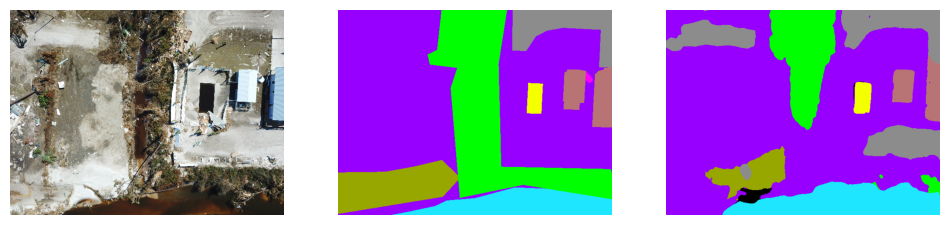

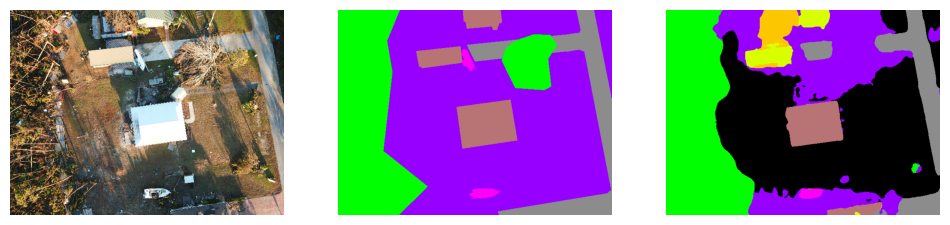

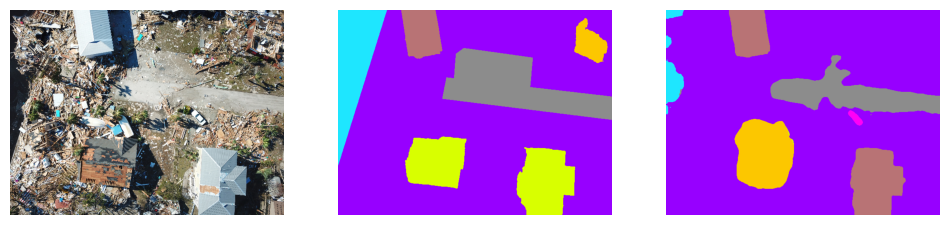

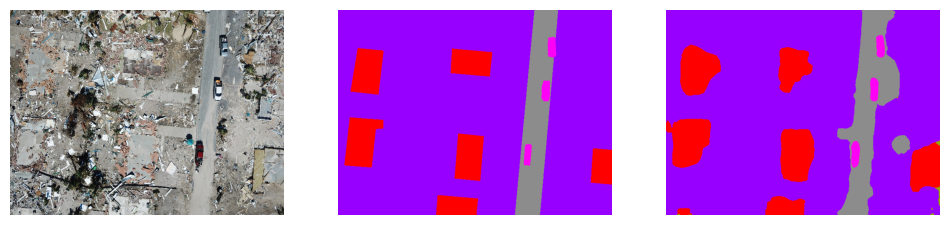

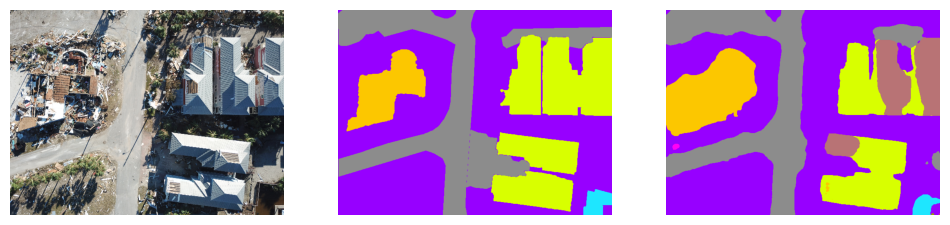

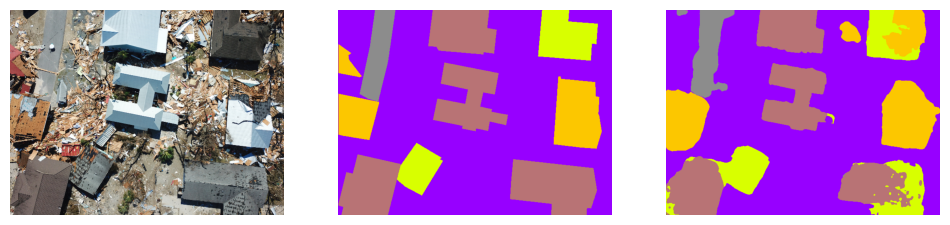

In [36]:
imglist=[15783, 13205,11236, 10844, 12272,11669]
origin_dir = '/kaggle/input/rescuenet/RescueNet/test/test-org-img/'
anno_dir = '/kaggle/input/rescuenet/RescueNet/test/test-label-img/'
for i in imglist:
    origin_img = f'{origin_dir}{i}.jpg'
    anno_img = f'{anno_dir}{i}_lab.png'
    visualize_one(origin_img, anno_img)


# Test

In [25]:

def test_one_epoch(model, test_loader, DEVICE=DEVICE):
    model.eval()
    with torch.no_grad():
        IoU_List = np.zeros(shape=12, dtype='float32')
        Fscore_List = np.zeros(shape=12, dtype='float32')
        
        iou_metric = smp.utils.metrics.IoU()  
        fscore_metric = smp.utils.metrics.Fscore()

        loop = tqdm(test_loader)
        
        for batch_index, (imgs, masks) in enumerate(loop):
            preds = model(imgs.to(DEVICE))  # shape [8,12,h,w]
            
            masks = masks.permute(1, 0, 2, 3)  # shape [12,8,h,w]
            preds_argmax = torch.argmax(preds, axis=1)  # shape [8,h,w]
            
            preds_stacked = (preds_argmax == 0).unsqueeze(0)  # shape [1,8,h,w]
            for i in range(1, 12):
                preds_stacked = torch.cat((preds_stacked, (preds_argmax == i).unsqueeze(0)))
                
            preds_stacked = preds_stacked.to(dtype=torch.int8)  # shape [12,8,h,w]

            for i in range(12):
                preds_layer = preds_stacked[i]  # shape [8,h,w]
                masks_layer = masks[i]  # shape [8,h,w]
                
                preds_layer = preds_layer.flatten()  # shape [8*h*w]
                masks_layer = masks_layer.flatten()  # shape [8*h*w]
                
                layer_iou = iou_metric(preds_layer.cpu(), masks_layer)  # one float number
                layer_fscore = fscore_metric(preds_layer.cpu(), masks_layer)  # one float number
                
                IoU_List[i] += layer_iou
                Fscore_List[i] += layer_fscore
                
            loop.set_postfix(
                background=IoU_List[0]/(batch_index+1),
                debris=IoU_List[1]/(batch_index+1),
                water=IoU_List[2]/(batch_index+1),
                building_no_damage=IoU_List[3]/(batch_index+1),
                building_minor_damage=IoU_List[4]/(batch_index+1),
                building_major_damage=IoU_List[5]/(batch_index+1),
                building_total_destruction=IoU_List[6]/(batch_index+1),
                vehicle=IoU_List[7]/(batch_index+1),
                road=IoU_List[8]/(batch_index+1),
                pool=IoU_List[9]/(batch_index+1),
                tree=IoU_List[10]/(batch_index+1),
                sand=IoU_List[11]/(batch_index+1),
                mean_IoU=IoU_List[1:12].mean()/(batch_index+1),
                mean_Fscore=Fscore_List[1:12].mean()/(batch_index+1)
            )

        IoU_List = IoU_List / len(test_loader)
        Fscore_List = Fscore_List / len(test_loader)

        print("background IoU = {}".format(IoU_List[0]))
        print("debris IoU = {}".format(IoU_List[1]))
        print("water IoU = {}".format(IoU_List[2]))
        print("building-no-damage IoU = {}".format(IoU_List[3]))
        print("building-minor-damage IoU = {}".format(IoU_List[4]))
        print("building-major-damage IoU = {}".format(IoU_List[5]))
        print("building-total-destruction IoU = {}".format(IoU_List[6]))
        print("vehicle IoU = {}".format(IoU_List[7]))
        print("road IoU = {}".format(IoU_List[8]))
        print("tree IoU = {}".format(IoU_List[9]))
        print("pool IoU = {}".format(IoU_List[10]))
        print("sand IoU = {}".format(IoU_List[11]))
        


        print("Test got mean IoU {}".format(IoU_List[1:12].mean()))
        print("Test got mean F1_score {}".format(Fscore_List[1:12].mean()))


In [37]:
test_one_epoch(model, test_loader, DEVICE=DEVICE)

100%|██████████| 56/56 [01:20<00:00,  1.44s/it, background=0.24, building_major_damage=0.323, building_minor_damage=0.264, building_no_damage=0.509, building_total_destruction=0.405, debris=0.564, mean_Fscore=0.648, mean_IoU=0.534, pool=0.744, road=0.648, sand=0.552, tree=0.729, vehicle=0.49, water=0.646]       

background IoU = 0.2402265965938568
debris IoU = 0.5638383626937866
water IoU = 0.6460263133049011
building-no-damage IoU = 0.5088829398155212
building-minor-damage IoU = 0.2637959420681
building-major-damage IoU = 0.3228595554828644
building-total-destruction IoU = 0.4047761559486389
vehicle IoU = 0.49011024832725525
road IoU = 0.6481519937515259
tree IoU = 0.7440285682678223
pool IoU = 0.728681743144989
sand IoU = 0.5524784326553345
Test got mean IoU 0.5339663624763489
Test got mean F1_score 0.6483901143074036


## metrics: FLOPS
MACs and FLOPs for each layer:
formula is output_image_size * kernel shape * output_channels
* MACs: I × O
* FLOPs: 2 × (I × O) (since each MAC counts as two FLOPs)
* fps = (total_frames / batch_size) / total_inference_time
## https://medium.com/@pashashaik/a-guide-to-hand-calculating-flops-and-macs-fa5221ce5ccc

In [39]:
! pip install torchprofile 

In [40]:
from torchprofile import profile_macs
sample_data = torch.randn(1, 3,480, 640, ).cuda()

macs = profile_macs(model,sample_data)
print(f'The macs is {macs}')
print(f'The FLOPs is {macs*2}')

The macs is 37156608000
The FLOPs is 74313216000


In [41]:
import time

def measure_latency(model, input_data):
    start_time = time.time()
    # For GPU (PyTorch)
    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)

    start_event.record()
    output = model(input_data)
    end_event.record()
    torch.cuda.synchronize()

    end_time = time.time()
    inference_time = end_time - start_time
    return inference_time


measure_latency(model, sample_data)

0.037216901779174805

In [42]:

# Timing the model inference
start_time = time.time()
batch_sample_data = torch.randn(8, 3,480, 640, ).cuda()

# For GPU (PyTorch)
start_event = torch.cuda.Event(enable_timing=True)
end_event = torch.cuda.Event(enable_timing=True)

start_event.record()
output = model(batch_sample_data)
end_event.record()
torch.cuda.synchronize()

end_time = time.time()
inference_time = end_time - start_time

# Calculate FPS
batch_size = len(batch_sample_data)  # or whatever your batch size is
print(f"batch_size {batch_size}")
fps = batch_size / inference_time

print(f"Inference time: {inference_time:.4f} seconds")
print(f"FPS: {fps:.2f}")


batch_size 8
Inference time: 0.2851 seconds
FPS: 28.06


In [43]:
import time
import torch

def calculate_fps_latency(model, input_size, num_samples=100):
    model.eval()
    device = next(model.parameters()).device  # Get the device of the model (cuda or cpu)
    start_time = time.time()
    with torch.no_grad():
        for _ in range(num_samples):
            input_data = torch.rand(input_size).to(device)  # Move input data to the correct device
            output = model(input_data)
    end_time = time.time()
    
    total_time = end_time - start_time
    latency = (total_time / num_samples) * 1000  # in milliseconds
    fps = 1 / (total_time / num_samples)
    
    return fps, latency

input_size = (1, 3, 480, 640)
fps, latency = calculate_fps_latency(model, input_size)
print(f"FPS: {fps}")
print(f"Latency: {latency} ms")


FPS: 46.59089141887752
Latency: 21.463422775268555 ms
